# Analysis Pipeline for scRNA-seq Data from Native, Transplanted, and 3D organoid AT2 cells
### Louie, Moye, Wong et al. 2022 Cell Reports
Our study determined the ability of 3D AT2 organoids to retain progenitor function when transplanted into recipeint mice.

This notebook describes the bioinformatics analysis used to understand transcriptional states associated with Native AT2 cells (CD31- CD45- EPCAM+ SCA1+), 3D AT2 organoids, and 3D AT2 organoids after being transplanted into recipient mice. Unlike the SCA1- dataset native SCA1+ EpCAM+ calls were collected from different mice on different days.

## Raw reads and 10X Geonmics files can be found using the accession code - GEO: GSE190565

In [1]:
# packages

import os
import glob
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from seaborn import despine
from seaborn import axes_style
from matplotlib.pyplot import suptitle
import matplotlib.colors
import scanpy.external as sce  # imputation
import scanorama # batch correction
from matplotlib.ticker import FormatStrFormatter

sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

/home/alm72/.conda/envs/sharon_org_env/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.6 anndata==0.7.1 umap==0.4.4 numpy==1.18.5 scipy==1.4.1 pandas==1.0.4 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2


#### Data pre-processing

In [6]:
filenames = [
# TRANSPLANTED AND ORGANOID SCA1+ DATA
'PATH_TO_FILES/SL7 Sca1+ M1 dsRed_filtered_feature_bc_matrix.h5',
'PATH_TO_FILES/SL8 Sca1+ M2 dsRed_filtered_feature_bc_matrix.h5',
'PATH_TO_FILES/SL9 Sca1+ Org1_filtered_feature_bc_matrix.h5',
'PATH_TO_FILES/SL10 Sca1+ Org2_filtered_feature_bc_matrix.h5',
'PATH_TO_FILES/SL11 Sca1+ Org3_filtered_feature_bc_matrix.h5',

# NATIVE SCA1+ DATA
'PATH_TO_FILES/SCA1POS_Mouse_1_native_no_injury.h5',
'PATH_TO_FILES/SCA1POS_Mouse_2_native_no_injury.h5',
'PATH_TO_FILES/SCA1POS_Mouse_3_native_no_injury.h5'
]

bdatas = [sc.read_10x_h5(filename) for filename in filenames]
bdata = bdatas[0].concatenate(bdatas[1:],
batch_categories=['SL7','SL8','SL9','SL10','SL11','IW1','IW3','IW5'])

bdata.var_names_make_unique() 
mito_genes = bdata.var_names.str.startswith('mt-')
bdata.obs['percent_mito'] = np.sum(bdata[:, mito_genes].X, axis=1).A1 / np.sum(bdata.X, axis=1).A1
bdata.obs['n_counts'] = bdata.X.sum(axis=1).A1

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Vari

... storing 'feature_types' as categorical
... storing 'genome' as categorical


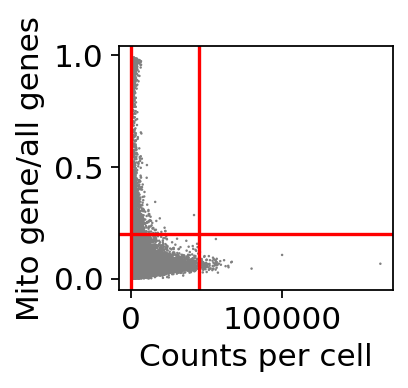

In [7]:
# Determine filtering cutoffs

with axes_style({'axes.grid': False}):
     rcParams['figure.figsize']=3,2
     sc.pl.scatter(bdata, y='percent_mito', x='n_counts', size=5, show = False)
     plt.axvline(45000, color='red')
     plt.axvline(200, color='red')
     plt.axhline(0.2, color='red')
     plt.xlabel('Counts per cell')
     plt.ylabel('Mito gene/all genes')

### Perform data pre-processing. Because native and transplanted/org data was collected at different times the datasets were batch corrected using Scanorama (https://pubmed.ncbi.nlm.nih.gov/31061482/). Hie et al 2019 Nature Biotechnology

In [9]:
'''
Filter normalize, and log the data
'''

bdata = bdata[bdata.obs['percent_mito'] < 0.2, :]
bdata = bdata[bdata.obs['n_counts'] < 45000, :]
bdata = bdata[bdata.obs['n_counts'] > 200, :]
sc.pp.filter_genes(bdata, min_counts=1)
sc.pp.filter_genes(bdata, min_cells=3)

sc.pp.normalize_per_cell(bdata) # library size normalize
sc.pp.log1p(bdata)
bdata.raw = bdata

'''
Annotate the data based on its library of origin
'''

scores = bdata.obs[['batch']]

annotation = pd.Series('Unknown', index=scores.index)

annotation[(scores.batch == 'SL7')|(scores.batch == 'SL8')|(scores.batch == 'SL9')|
(scores.batch == 'SL10')|(scores.batch == 'SL11')] = 'sharon'  

annotation[(scores.batch == 'IW1')|(scores.batch == 'IW3')|(scores.batch == 'IW5')] = 'irene' 

bdata.obs['library'] = annotation

'''
find hvg common in all the libraries for batch correction
'''

sc.pp.highly_variable_genes(bdata, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'library')

print("Highly variable genes intersection: %d"%sum(bdata.var.highly_variable_intersection))
print("Number of batches where gene is variable:")
print(bdata.var.highly_variable_nbatches.value_counts())
var_genes_batch = bdata.var.highly_variable_nbatches > 0

print("Any batch var genes: %d"%sum(var_genes_batch))
print("Variable genes in all batches: %d"%sum(bdata.var.highly_variable_nbatches == 2))

var_select = bdata.var.highly_variable_nbatches == 2
var_genes = var_select.index[var_select]
len(var_genes)

batches = ['sharon', 'irene']
alldata = {}
for batch in batches:
    alldata[batch] = bdata[bdata.obs['library'] == batch,]

alldata

alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes]

#convert to list of AnnData objects
bdatas = list(alldata2.values())

Trying to set attribute `.var` of view, copying.
... storing 'library' as categorical


Highly variable genes intersection: 725
Number of batches where gene is variable:
0    15811
1     2942
2      725
Name: highly_variable_nbatches, dtype: int64
Any batch var genes: 3667
Variable genes in all batches: 725
sharon
irene


In [10]:
# run scanorama.integrate
scanorama  = scanorama.integrate_scanpy(bdatas, dimred = 50,)

# returns a list of 2 np.ndarrays with 50 columns.

print(scanorama[0].shape)
print(scanorama[1].shape)

# make into one matrix.
all_s = np.concatenate(scanorama)
print(all_s.shape)

# add to the AnnData object
bdata.obsm["SC"] = all_s

Found 725 genes among all datasets
[[0.         0.41213494]
 [0.         0.        ]]
Processing datasets (0, 1)
(14299, 50)
(7944, 50)
(22243, 50)


In [ ]:
'''''''''
Visulize effect of imputation at different t values

'''''''''
sc.pp.filter_genes(adata, min_counts=1)

from matplotlib.ticker import FormatStrFormatter # manually set # y tick decimal places
import time
import scanpy.external as sce

start = time.time()

# seperate adatas
adata2 = adata.copy()
adata5 = adata.copy()
adata7 = adata.copy()

# impute
print('Performing MAGIC')
sce.pp.magic(adata2, name_list='all_genes', knn=5, t=2, n_pca=20)
sce.pp.magic(adata5, name_list='all_genes', knn=5, t=5, n_pca=20)
sce.pp.magic(adata7, name_list='all_genes', knn=5, t=7, n_pca=20)

# plot sftpc-lyz2 correlation after different imputation t values 
adata_list = [adata, adata2, adata5, adata7]
print('Plotting data')
    
for i in adata_list:
    with axes_style({'axes.grid': False}):
        ax = sc.pl.scatter(i, x='Sftpc', y='Lyz2', size=5, use_raw=False, show=False)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
end = time.time()
print('Total run time (min):', (end - start)/60)

#### Perform data denoising using MAGIC (https://pubmed.ncbi.nlm.nih.gov/29961576/). van Dijk et al 2018 Cell
* Multiple t values were visualized to determine the impact of data denoising to avoid over correction.
* Two genes knwon to be expression in AT2 cells (Lyz2 and Sftpc) were used.

In [11]:
'''
Use optimal t value to impute the data
'''
sce.pp.magic(bdata, name_list='all_genes', knn=5, t=5, n_pca=20)

# Scanorama creates a PCA embedding so there is no need to recalculate PCA
sc.pp.neighbors(bdata, n_neighbors=5, n_pcs=20, use_rep='SC')
sc.tl.umap(bdata)

  Running MAGIC with `solver='exact'` on 19478-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


/home/alm72/.conda/envs/sharon_org_env/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


In [12]:
#### Number of cells after filtering
print('Number of cells after filtering:', len(bdata.obs.index))

Number of cells after filtering: 22243


#### Plot batches seperately on a UMAP embedding

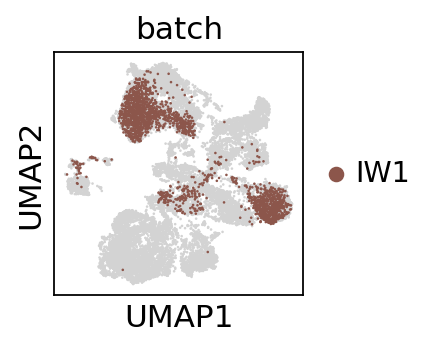

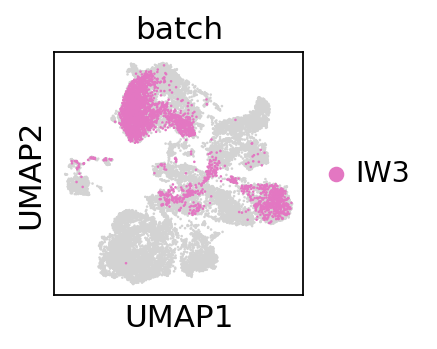

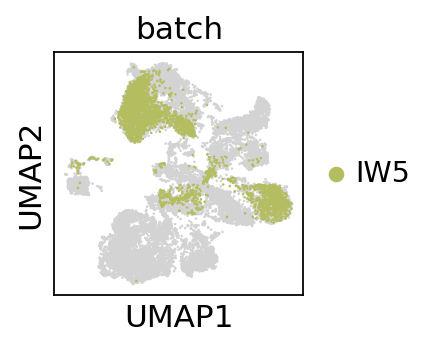

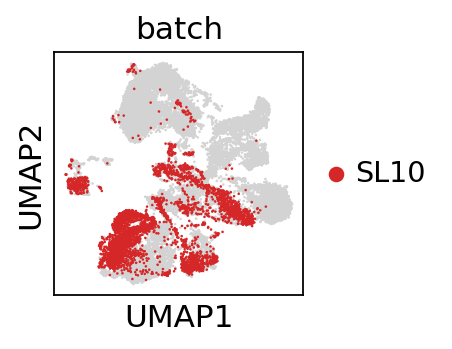

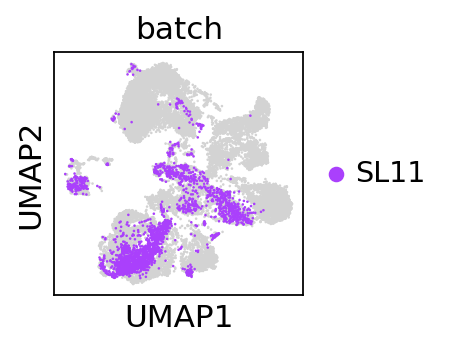

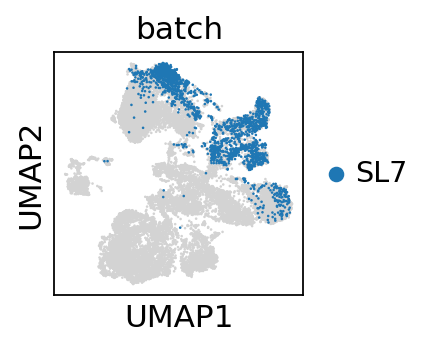

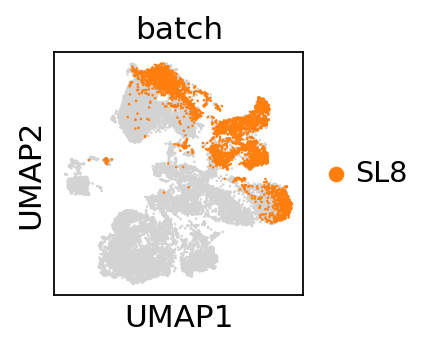

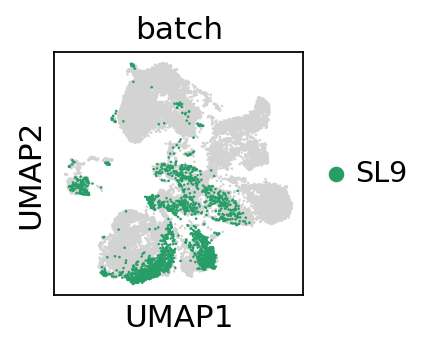

In [13]:
rcParams['figure.figsize']=2,2

for i in sorted(list(set(bdata.obs.batch))):
    rcParams['figure.facecolor']='white'
    rcParams['figure.figsize']=2,2
    sc.pl.umap(bdata, color=['batch'], groups=i, frameon=True, show=False)

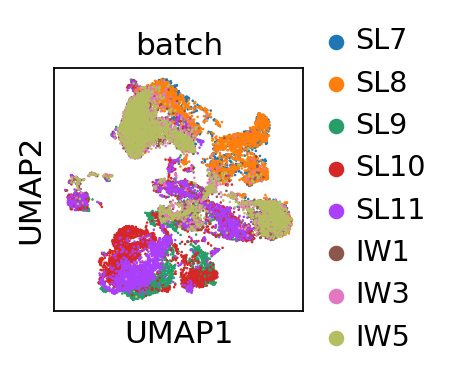

In [2]:
rcParams['figure.figsize']=2,2

rcParams['figure.facecolor']='white'
rcParams['figure.figsize']=2,2
sc.pl.umap(bdata, color=['batch'], frameon=True, show=False)

#### Check for stromal contamination

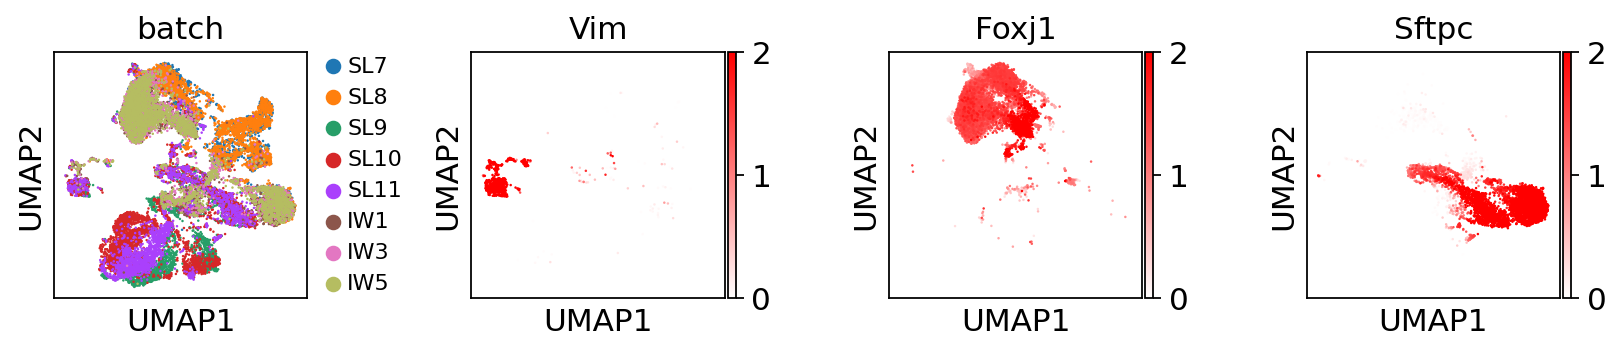

In [14]:
# Check expression of specific epithelial genes

bdata_scaled = sc.pp.scale(bdata, copy=True)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white','red'])

sc.pl.umap(bdata_scaled, color=['batch','Vim','Foxj1','Sftpc'], wspace=0.5, legend_fontsize=10,legend_loc='right margin', 
size=5, frameon=True, color_map=cmap, use_raw=False, vmin=0, vmax=2)

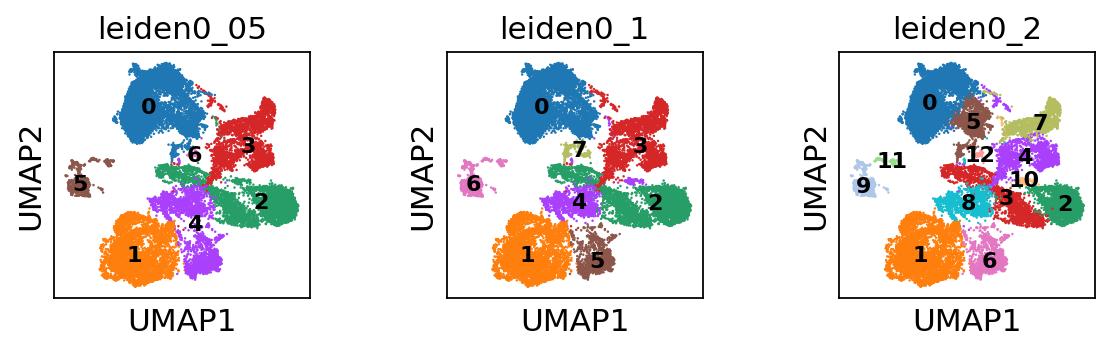

In [15]:
sc.tl.leiden(bdata, resolution=0.05, key_added='leiden0_05')
sc.tl.leiden(bdata, resolution=0.1, key_added='leiden0_1')
sc.tl.leiden(bdata, resolution=0.2, key_added='leiden0_2')

leiden_clusts=['leiden0_05','leiden0_1','leiden0_2']

rcParams["figure.facecolor"]='white'
rcParams['figure.figsize'] = 2,2
sc.pl.umap(bdata, color=leiden_clusts, hspace=0.5, legend_fontsize=10,legend_loc='on data', size=5, 
frameon=True, show=False)

#### Remove clusters with less than 100 cells or with high stromal gene expression or dont have contributions from matching batches

In [16]:
print(bdata.obs['leiden0_1'].value_counts())

0    7300
1    4397
2    4228
3    2973
4    1277
5    1221
6     659
7     188
Name: leiden0_1, dtype: int64


#### Remove clusters composed of a single batch

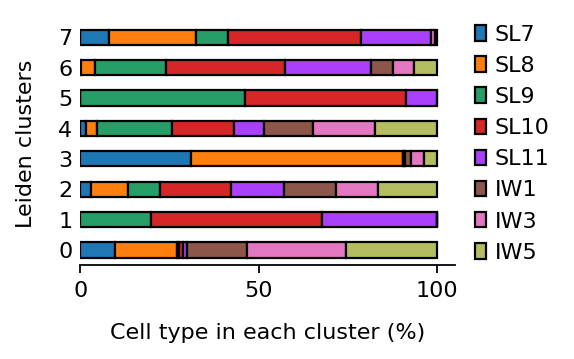

In [18]:
df=bdata.obs.copy()
df_plot = df.groupby(['leiden0_1', 'batch']).size().reset_index().pivot(columns='batch', index='leiden0_1', values=0)

# normalize rows
# Credit: https://stackoverflow.com/questions/26537878/pandas-sum-across-columns-and-divide-each-cell-from-that-value
df3 = df_plot.div(df_plot.sum(axis=1), axis=0)

# plot

rcParams['figure.figsize'] = 3,2
with axes_style({'axes.grid': False}):
    ax = df3.plot(kind='barh', stacked=True, edgecolor='black')
    ax.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1, frameon=False, title='', 
    title_fontsize=10, fontsize=10)
    ax.set_ylabel("Leiden clusters", rotation=90, labelpad=10, fontsize=10)
    ax.set_xlabel("Cell type in each cluster (%)", rotation=0, labelpad=10, fontsize=10)
    ax.set_yticklabels(df3.index, fontsize=10)
    ax.set_xticklabels([0,50,100], fontsize=10)
    ax.tick_params(axis=u'y', which=u'both',length=0)
    despine(right=True, left=True)

In [20]:
'''
Reason removed:
Cluster 6 - stromal

'''

bdata_subset = bdata[bdata.obs['leiden0_1'].isin(['0','1','2','3','4','5','7'])]

# rename leiden0_05
new_cluster_names = ['0','1','2','3','4','5','6']
bdata_subset.rename_categories('leiden0_1', new_cluster_names)

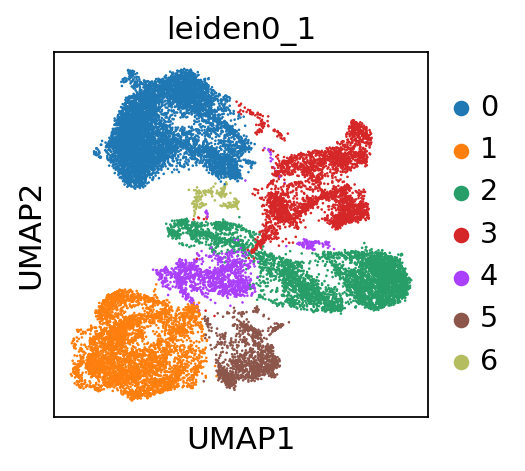

In [21]:
rcParams['figure.figsize']=3,3
rcParams['figure.facecolor']='white'
sc.pl.umap(bdata_subset, color='leiden0_1')

#### Add group annotations to anndata.obs

In [22]:
'''Group sample annotations then re-plot bar_graphs'''

scores = bdata_subset.obs[['batch']]

annotation = pd.Series('Unknown', index=scores.index)

# Add annotations
annotation[(scores.batch == 'SL9')|(scores.batch == 'SL10')|(scores.batch == 'SL11')] = 'Sca1+ Organoid' 
annotation[(scores.batch == 'SL7')|(scores.batch == 'SL8')|(scores.batch == 'SL15')] = 'Sca1+ DsRed+' 
annotation[(scores.batch == 'IW1')|(scores.batch == 'IW3')|(scores.batch == 'IW5')] = 'Sca1+ DsRed-' 

 
bdata_subset.obs['grouped_annotations'] = annotation

Trying to set attribute `.obs` of view, copying.


... storing 'grouped_annotations' as categorical


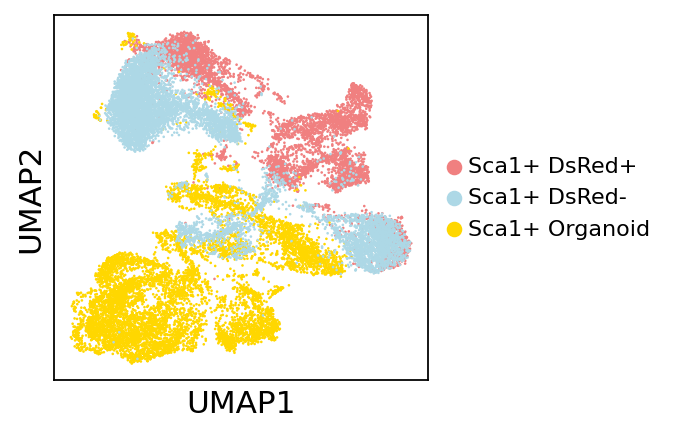

In [23]:
rcParams['figure.figsize'] = 3,3
rcParams['figure.facecolor'] = 'white'
sc.pl.umap(
    bdata_subset, 
    color='grouped_annotations',
    legend_loc = 'right margin',
    legend_fontsize = 10,
    palette = ['#f08080','#add8e6', '#ffd700'],
    show = False, frameon=True, title=''
)

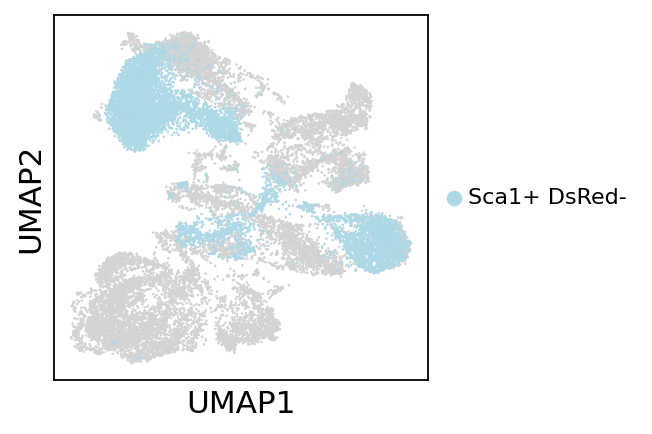

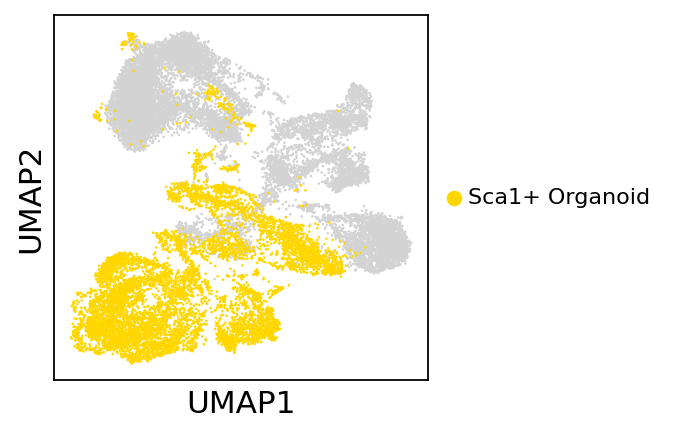

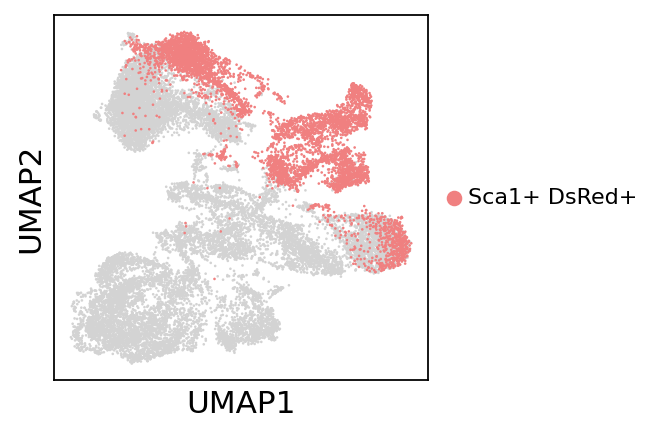

In [2]:
# Annotations plotted seperately

for i in list(set(bdata_subset.obs.grouped_annotations)):
    rcParams['figure.figsize'] = 3,3
    rcParams['figure.facecolor'] = 'white'
    sc.pl.umap(
        bdata_subset, 
        color='grouped_annotations',
        groups=i,
        legend_loc = 'right margin',
        legend_fontsize = 10,
        show = False, frameon=True, title=''
    )

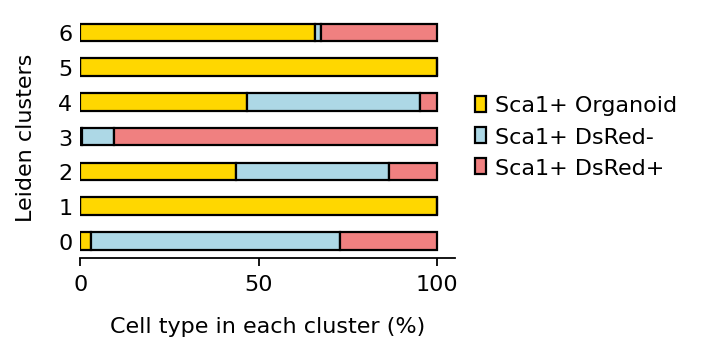

In [25]:
# Cell type contribution

df=bdata_subset.obs.copy()
df_plot = df.groupby(['leiden0_1', 'grouped_annotations']).size().reset_index().pivot(columns='grouped_annotations', 
                                                                                      index='leiden0_1', values=0)
# normalize rows
# Credit: https://stackoverflow.com/questions/26537878/pandas-sum-across-columns-and-divide-each-cell-from-that-value
df3 = df_plot.div(df_plot.sum(axis=1), axis=0)

order = ['Sca1+ Organoid', 'Sca1+ DsRed-', 'Sca1+ DsRed+']
df3 = df3[order]

# plot

color = ['#ffd700','#add8e6','#f08080']

rcParams['figure.figsize'] = 3,2
with axes_style({'axes.grid': False}):
    ax = df3.plot(kind='barh', stacked=True, edgecolor='black', color = color)
    ax.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1, frameon=False, title='', 
    title_fontsize=10, fontsize=10)
    ax.set_ylabel("Leiden clusters", rotation=90, labelpad=10, fontsize=10)
    ax.set_xlabel("Cell type in each cluster (%)", rotation=0, labelpad=10, fontsize=10)
    ax.set_yticklabels(df3.index, fontsize=10)
    ax.set_xticklabels([0,50,100], fontsize=10)
    ax.tick_params(axis=u'y', which=u'both',length=0)
    despine(right=True, left=True)

### Batch contributions. More descriptive names were used in the manuscript

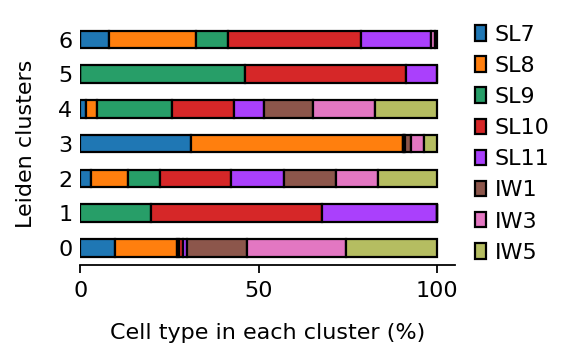

In [26]:
df=bdata_subset.obs.copy()
df_plot = df.groupby(['leiden0_1', 'batch']).size().reset_index().pivot(columns='batch', index='leiden0_1', values=0)

# normalize rows
# Credit: https://stackoverflow.com/questions/26537878/pandas-sum-across-columns-and-divide-each-cell-from-that-value
df3 = df_plot.div(df_plot.sum(axis=1), axis=0)

# plot

rcParams['figure.figsize'] = 3,2
with axes_style({'axes.grid': False}):
    ax = df3.plot(kind='barh', stacked=True, edgecolor='black')
    ax.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1, frameon=False, title='', 
    title_fontsize=10, fontsize=10)
    #ax.set_xlabel("Ratio", rotation=0, labelpad=10, fontsize=10)
    ax.set_ylabel("Leiden clusters", rotation=90, labelpad=10, fontsize=10)
    ax.set_xlabel("Cell type in each cluster (%)", rotation=0, labelpad=10, fontsize=10)
    ax.set_yticklabels(df3.index, fontsize=10)
    ax.set_xticklabels([0,50,100], fontsize=10)
    ax.tick_params(axis=u'y', which=u'both',length=0)
    despine(right=True, left=True)

#### DE Analysis

In [27]:
ngenes = 3000
method = 'wilcoxon'
groupby = 'leiden0_1'

sc.tl.rank_genes_groups(bdata_subset, groupby=groupby, key_added=f'rank_genes_{groupby}',
method = method, n_genes = ngenes, use_raw = True)

# save data to bdata_subset.uns
result = bdata_subset.uns[f'rank_genes_{groupby}']
groups = result['names'].dtype.names

de_data = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
de_data.to_excel("/n/data2/bch/hemonc/ckim/SHARON/sca1_pos_DE_SLIWmerge_scanorama.xlsx", sheet_name='Sheet1')

Total marker_genes in cluster0 with pval<0.01 2300
Total marker_genes in cluster1 with pval<0.01 3000
Total marker_genes in cluster2 with pval<0.01 2379
Total marker_genes in cluster3 with pval<0.01 1846
Total marker_genes in cluster4 with pval<0.01 1142
Total marker_genes in cluster5 with pval<0.01 3000
Total marker_genes in cluster6 with pval<0.01 3000


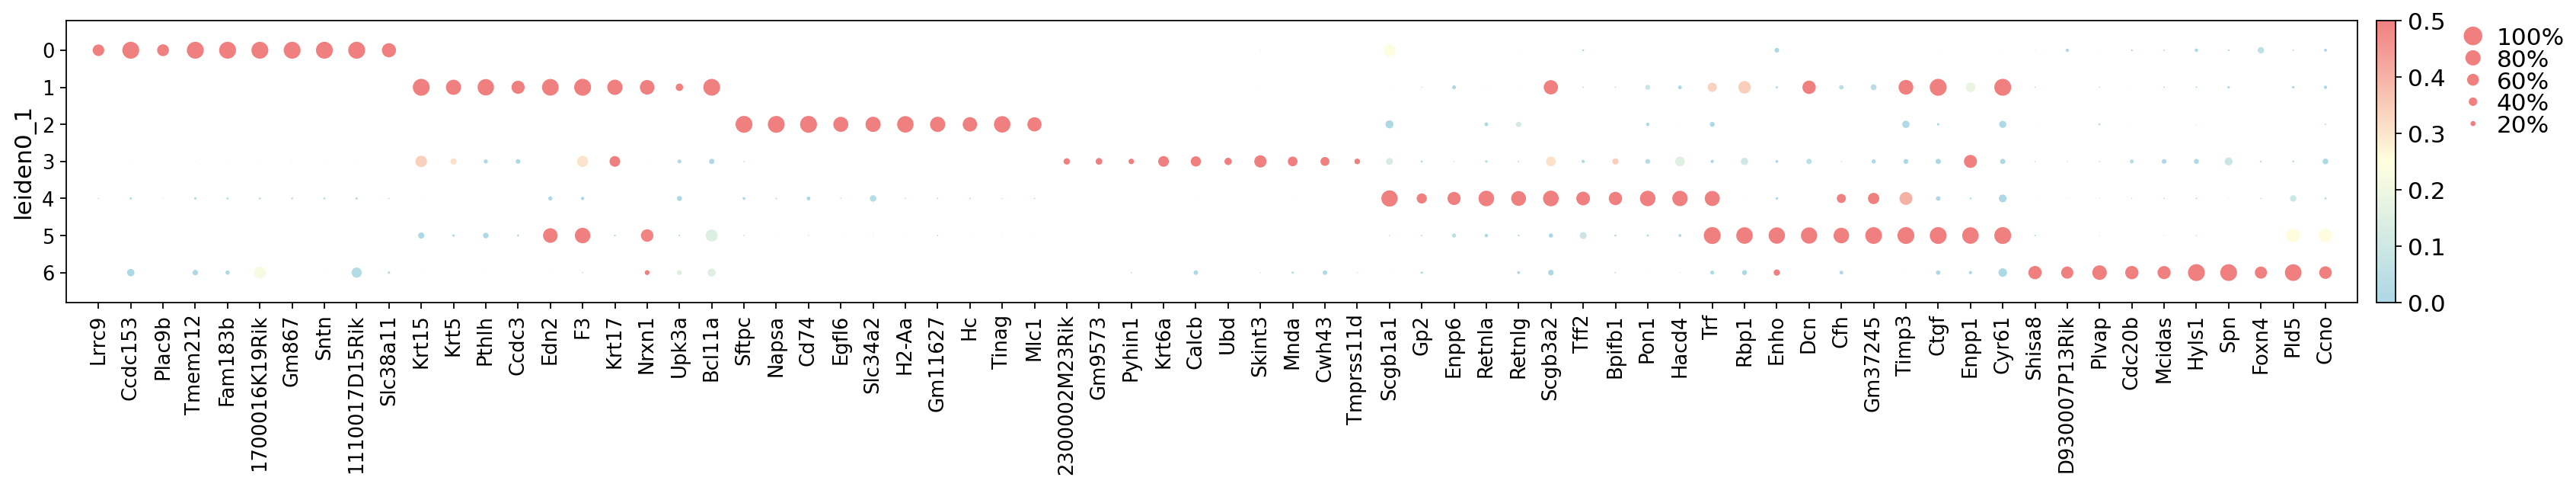

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[24.5, 0, 0.2, 0.5, 0.25])

In [29]:
# create list of cluster names and sort numerically
clusters = list(set(bdata_subset.obs.leiden0_1))

# order list numerically
clusters.sort(key=int)

l = []
top_DE_genes = dict()

for i in clusters:
    df1 = de_data.loc[(de_data[f'{i}_p'] < 0.01)] 
    df1 = df1[[f'{i}_n',f'{i}_p',f'{i}_l']]
    df1 = df1.sort_values(by=f'{i}_l', ascending=False)
    top_genes = df1[f'{i}_n'].tolist()
    top_DE_genes.update({i:top_genes}) # dict for saving
    print(f'Total marker_genes in cluster{i} with pval<0.01', len(top_genes))
    top = top_genes[:10] 
    l.append(top)

# Merge lists
top_de_genes = []
for sublist in l:
    for item in sublist:
        top_de_genes.append(item)

scaled = sc.pp.scale(bdata_subset, copy=True)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['lightblue','lightyellow','lightcoral'])
sc.pl.dotplot(scaled, top_de_genes, color_map=cmap, groupby='leiden0_1', use_raw=False,
             vmin=0, vmax=0.5)

#### Calculate signature scores

In [ ]:
import time

start = time.time()

# create cell barcodes column in adata.obs using the index
bdata_subset.obs['cell_barcodes'] = bdata_subset.obs.index

# Dictionary with cell type (key) and genes (values)
epi_marker_dict = {}


print('Adding PanglaoDB Cell Signatures')
epi_df = pd.read_excel('/n/data2/bch/hemonc/ckim/AARON/20190114_KRASYFP_7weeks/scanpy_analysis/epithelial_mesenchymal_marker_genes.xlsx', sheet_name='epithelial', header=0)
celltype_list = ['Pulmonary alveolar type II cells','Pulmonary alveolar type I cells','Clara cells','Ciliated cells', 'Goblet cells', 'Basal cells']

for i in celltype_list:
        subset = epi_df.loc[(epi_df['cell type'] == i) & (epi_df['species'] != 'Hs')]
        genes = subset['official gene symbol'].tolist()
        genes = [x.lower() for x in genes] # lower names
        genes = [x.capitalize() for x in genes] # capitalize names
        epi_marker_dict.update({i:genes})

# GO signatures
print('Adding GO signatures to dictionary')
lung_epi_dev = pd.read_excel('/n/data2/bch/hemonc/ckim/AARON/KY_organoid_analysis/Lung_epithelial_development_GO0060428.xlsx', sheet_name='Sheet0', header=0)

GO_lists = [lung_epi_dev, cilia, flagellum]
GO_names = ['GO:Lung epithelial dev']

for lists, name in zip(GO_lists, GO_names):
    input_list = list(set(lists['Symbol'])) # remove duplicates
    final_list = [x for x in input_list if x in bdata_subset.var_names]
    epi_marker_dict.update({name:final_list})

print('Adding HALLMARK signatures to dictionary')
# Hallmark genes
wnt = pd.read_excel('/n/data2/bch/hemonc/ckim/SHARON/20200211_transplant_scRNASeq/scanpy_analysis/signatures/hallmark_wnt.xlsx', sheet_name='hallmark_wnt', header=0)
notch = pd.read_excel('/n/data2/bch/hemonc/ckim/SHARON/20200211_transplant_scRNASeq/scanpy_analysis/signatures/hallmark_notch.xlsx', sheet_name='hallmark_notch', header=0)
tgfb = pd.read_excel('/n/data2/bch/hemonc/ckim/SHARON/20200211_transplant_scRNASeq/scanpy_analysis/signatures/hallmark_tgfb.xlsx', sheet_name='hallmark_tgfb', header=0)

hallmark_lists = [wnt, notch, hedgehog, tgfb, ox_phos, inflam]
sig_names = ['Hallmark_WNT', 'Hallmark_Notch', 'Hallmark_Tgfb']

# Add gene signatures to marker dictionary
for lists, name in zip(hallmark_lists, sig_names):
    inital_list = list(lists['Genes']) # Make list of gene names
    list2 = [x for x in inital_list if str(x) != 'nan'] # remove nan
    list2 = [x.lower() for x in list2] # lower names
    list2 = [x.capitalize() for x in list2] # capitalize names
    list_final = [x for x in list2 if x in bdata_subset.var_names] # remove genes not in adata.var
    epi_marker_dict.update({name:list_final})

# print genes per dict key
for k,v in epi_marker_dict.items():
    print(f'{k}:', len(v))
    
# Calculate score
def evaluate_partition(anndata, marker_dict, gene_symbol_key=None, partition_key=None):
    # Inputs:
    #    anndata         - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or 
    #                      an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker 
    #                      genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                      'louvain_r1' 

    #Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise
        
    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names
        
    
    # I created a column based on index. This allows z-score calculation on single cells rather than clusters
    clusters = np.unique(anndata.obs[partition_key])
    n_clust = len(clusters)
    n_groups = len(marker_dict)
    
    marker_res = np.zeros((n_groups, n_clust))
    z_scores = sc.pp.scale(anndata, copy=True) # original data is not scaled

    i = 0
    for group in marker_dict:
        print(f'Calculating signature for {group}')
        # Find the corresponding columns and get their mean expression in the cluster
        j = 0
        for clust in clusters:
            cluster_cells = np.in1d(z_scores.obs[partition_key], clust)
            marker_genes = np.in1d(gene_ids, marker_dict[group])
            marker_res[i,j] = z_scores.X[np.ix_(cluster_cells,marker_genes)].mean()
            j += 1
        i+=1

    variances = np.nanvar(marker_res, axis=0)
    if np.all(np.isnan(variances)):
        print("No variances could be computed, check if your cell markers are in the data set.")
        print("Maybe the cell marker IDs do not correspond to your gene_symbol_key input or the var_names")
        raise

    marker_res_df = pd.DataFrame(marker_res, columns=clusters, index=marker_dict.keys())
    
    return marker_res_df

# Calculate signature scores for each cell
df = evaluate_partition(bdata_subset, epi_marker_dict, gene_symbol_key=None, 
partition_key = 'cell_barcodes')

# Transpose the dataframe
df_transposed = df.transpose()

# Add data to adata.obs
for column in df_transposed.columns:
    bdata_subset.obs[column] = df_transposed[column]

end = time.time()
print('Total run time (min):', (end - start)/60)

#### Clustermaps using pathways of interest

/home/alm72/.conda/envs/sharon_org_env/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


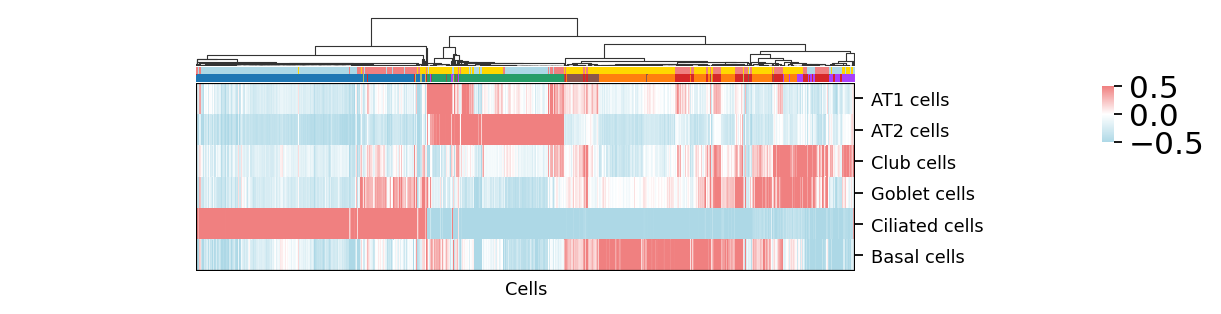

In [7]:
'''Get Clusters of Interest'''

cancer_df = bdata_subset.copy()

cancer_df.obs = cancer_df.obs.rename(columns={"Clara cells": "Club cells",
                                                "Pulmonary alveolar type II cells": "AT2 cells",
                                               "Pulmonary alveolar type I cells": "AT1 cells"})

df = pd.DataFrame(index=bdata_subset.obs.index)

pathways=['AT1 cells','AT2 cells', 'Club cells', 'Goblet cells', 'Ciliated cells', 'Basal cells']


for path in pathways:
    df[path]=cancer_df.obs[path]
 
z_scores = sc.pp.scale(cancer_df, copy=True)

cols=['AT1 cells','AT2 cells', 'Club cells', 'Goblet cells', 'Ciliated cells', 'Basal cells']

df = df[cols]
    
df = df.T

# leiden colors - first row

louvain = cancer_df.obs['leiden0_1'].astype('object')
lut = {
'0': '#1f77b4',
'1': '#ff7f0e',
'2': '#279e68',
'3': '#d62728',
'4': '#aa40fc',
'5': '#8c564b',
'6': '#b5bd61'
}

col_colors = louvain.map(lut)

# grouped annotations colors - third row
louvain3 = cancer_df.obs['grouped_annotations'].astype('object')
lut3 = {
'Sca1+ Organoid': 'gold',
'Sca1+ DsRed-': 'lightblue',
'Sca1+ DsRed+': 'lightcoral'
}

col_colors3 = louvain3.map(lut3)

# plot

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['lightblue','white','lightcoral'])

g = sb.clustermap(df, vmin=-0.5, vmax=0.5, cmap=cmap, metric="correlation", row_cluster=False, col_cluster=True,
                   figsize=(7, 5), cbar_pos=(1, 0.8, .01, .07), # locxaxis,locyaxis,cbarwidth,cbarheight
                   col_colors=[col_colors3, col_colors], dendrogram_ratio=0.2
                   ) 
ax = g.ax_heatmap
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel("Cells", fontsize=8)
ax.axhline(len(df.index), linewidth=1, color='black')
ax.axhline(0, linewidth=1, color='black')
ax.axvline(len(df.columns), linewidth=1, color='black')
ax.axvline(0, linewidth=1, color='black')

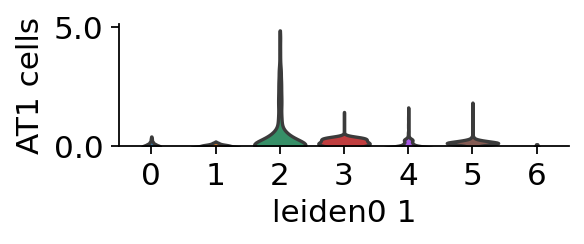

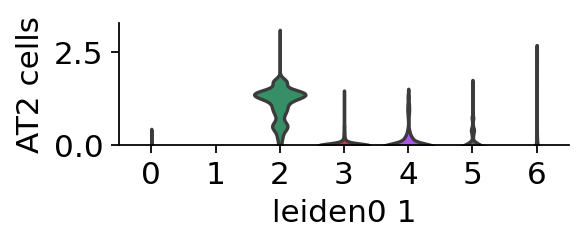

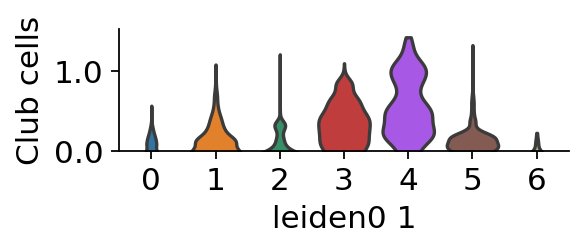

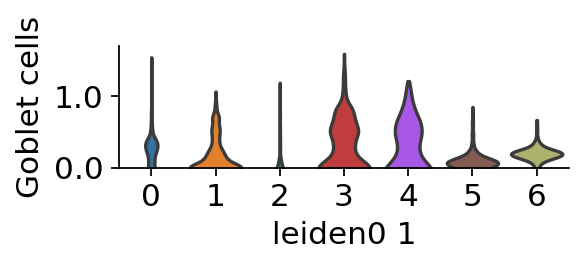

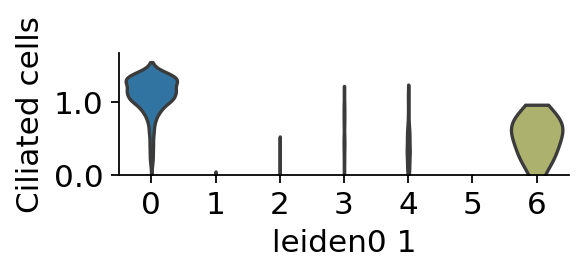

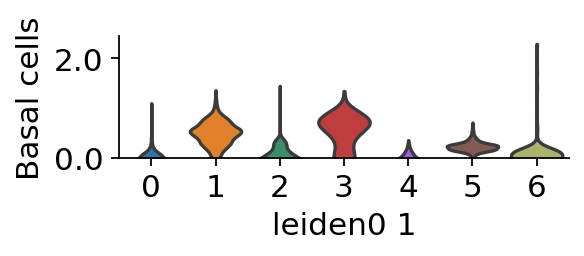

In [14]:
# Same signature score data visualized as violin plots

from matplotlib.ticker import FormatStrFormatter

# aesthetic renaming
cancer_df = bdata_subset.copy()

cancer_df.obs = cancer_df.obs.rename(columns={"Clara cells": "Club cells",
                                                "Pulmonary alveolar type II cells": "AT2 cells",
                                               "Pulmonary alveolar type I cells": "AT1 cells"})
# plot
lst=['AT1 cells','AT2 cells', 'Club cells', 'Goblet cells', 'Ciliated cells', 'Basal cells']

for gene in lst:
    rcParams['figure.figsize']=4,1
    with axes_style({'axes.grid': False}):
        ax=sc.pl.violin(cancer_df, keys=gene, groupby='leiden0_1', stripplot=False, jitter=False, show=False)
        despine(right=True)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_ylim(0)       

### Subset transplanted SPO cells for additional analysis

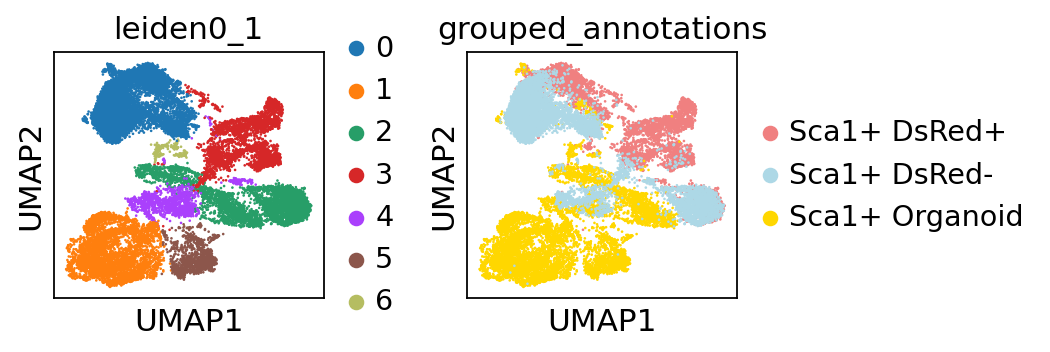

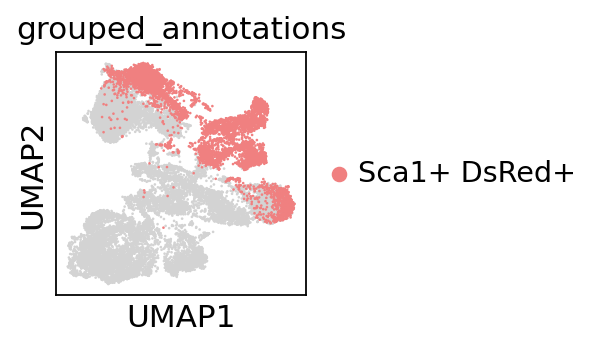

In [2]:
rcParams['figure.figsize']=2,2
rcParams['figure.facecolor']='white'

sc.pl.umap(bdata_subset, color=['leiden0_1', 'grouped_annotations'])
sc.pl.umap(bdata_subset, color=['grouped_annotations'], groups='Sca1+ DsRed+')

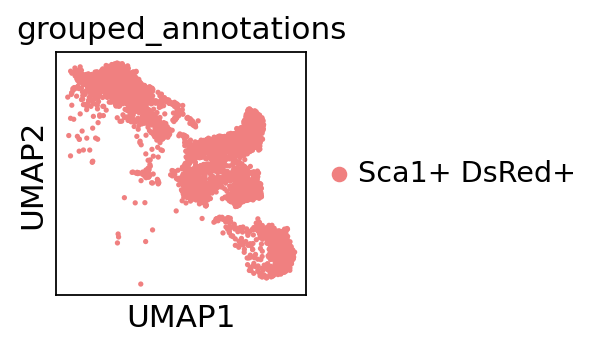

In [7]:
bdata_trans = bdata_subset[bdata_subset.obs['grouped_annotations'].isin(['Sca1+ DsRed+'])]
sc.pl.umap(bdata_trans, color=['grouped_annotations'])

#### Recompute UMAP

In [8]:
sc.pp.neighbors(bdata_trans, n_neighbors=5, n_pcs=20, use_rep='SC')
sc.tl.umap(bdata_trans)

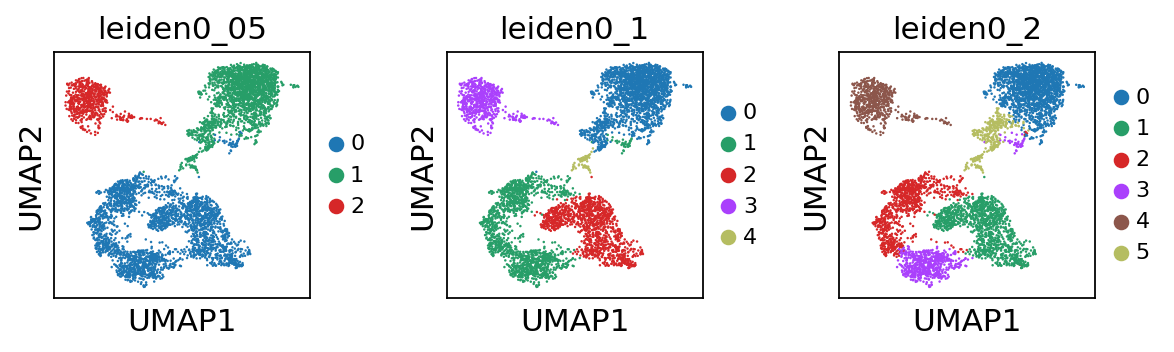

In [10]:
sc.tl.leiden(bdata_trans, resolution=0.05, key_added='leiden0_05')
sc.tl.leiden(bdata_trans, resolution=0.1, key_added='leiden0_1')
sc.tl.leiden(bdata_trans, resolution=0.2, key_added='leiden0_2')

leiden_clusts=['leiden0_05','leiden0_1','leiden0_2']

rcParams["figure.facecolor"]='white'
rcParams['figure.figsize'] = 2,2

sc.pl.umap(bdata_trans, color=leiden_clusts, hspace=0.5, legend_fontsize=10, legend_loc='right margin', 
size=5, frameon=True, show=False)

#### Change leiden0_1 colors - aesthetic

In [6]:
# change colors in .uns
new_colors = ['#2BFCF1','#FC2B97','#2BFC91','#FCF92B','#892BFC'] 

print('Old colors:',bdata_trans.uns['leiden0_1_colors'])
bdata_trans.uns.update({'leiden0_1_colors':new_colors})
print('New colors:',bdata_trans.uns['leiden0_1_colors'])

Old colors: ['#1f77b4' '#279e68' '#d62728' '#aa40fc' '#b5bd61']
New colors: ['#2BFCF1', '#FC2B97', '#2BFC91', '#FCF92B', '#892BFC']


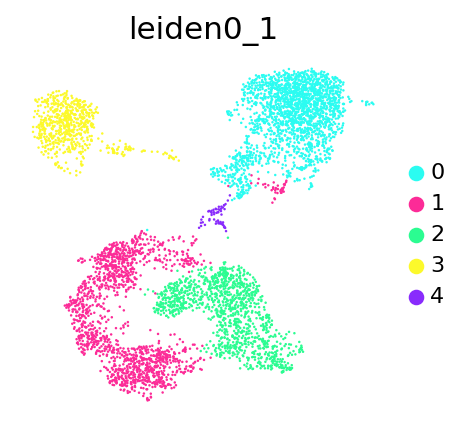

In [7]:
rcParams["figure.facecolor"]='white'
rcParams['figure.figsize'] = 3,3

sc.pl.umap(bdata_trans, color=['leiden0_1'], hspace=0.5, legend_fontsize=10, legend_loc='right margin', 
size=5, frameon=False, show=False)

#### Clustermap for transplant data

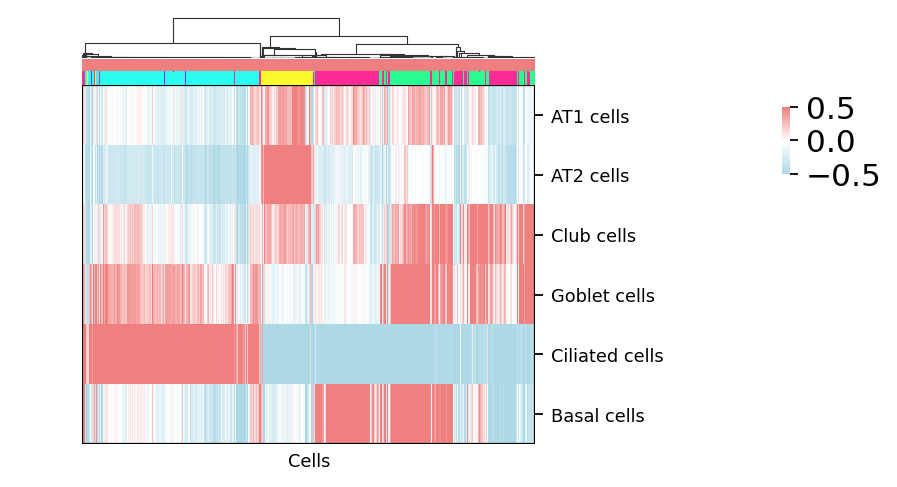

In [15]:
'''Get Clusters of Interest'''

cancer_df = bdata_trans.copy()

cancer_df.obs = cancer_df.obs.rename(columns={"Clara cells": "Club cells",
                                                "Pulmonary alveolar type II cells": "AT2 cells",
                                               "Pulmonary alveolar type I cells": "AT1 cells"})

df = pd.DataFrame(index=bdata_trans.obs.index)

pathways=['AT1 cells','AT2 cells', 'Club cells', 'Goblet cells', 'Ciliated cells', 'Basal cells']


for path in pathways:
    df[path]=cancer_df.obs[path]
 
z_scores = sc.pp.scale(cancer_df, copy=True)

cols=['AT1 cells','AT2 cells', 'Club cells', 'Goblet cells', 'Ciliated cells', 'Basal cells']

df = df[cols]
    
df = df.T

# leiden colors - first row

louvain = cancer_df.obs['leiden0_1'].astype('object')
lut = {
    '0':'#2BFCF1',
    '1':'#FC2B97',
    '2':'#2BFC91',
    '3':'#FCF92B',
    '4':'#892BFC'  
}

col_colors = louvain.map(lut)

# grouped annotations colors - third row
louvain3 = cancer_df.obs['grouped_annotations'].astype('object')
lut3 = {
'Sca1+ Organoid': 'gold',
'Sca1+ DsRed-': 'lightblue',
'Sca1+ DsRed+': 'lightcoral'
}

col_colors3 = louvain3.map(lut3)

# plot

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['lightblue','white','lightcoral'])

g = sb.clustermap(df, vmin=-0.5, vmax=0.5, cmap=cmap, metric="correlation", row_cluster=False, col_cluster=True,
                   figsize=(5, 6), cbar_pos=(1, 0.8, .01, .07), # locxaxis,locyaxis,cbarwidth,cbarheight
                   col_colors=[col_colors3, col_colors], dendrogram_ratio=0.1
                   ) 
ax = g.ax_heatmap
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel("Cells", fontsize=8)
ax.axhline(len(df.index), linewidth=1, color='black')
ax.axhline(0, linewidth=1, color='black')
ax.axvline(len(df.columns), linewidth=1, color='black')
ax.axvline(0, linewidth=1, color='black')

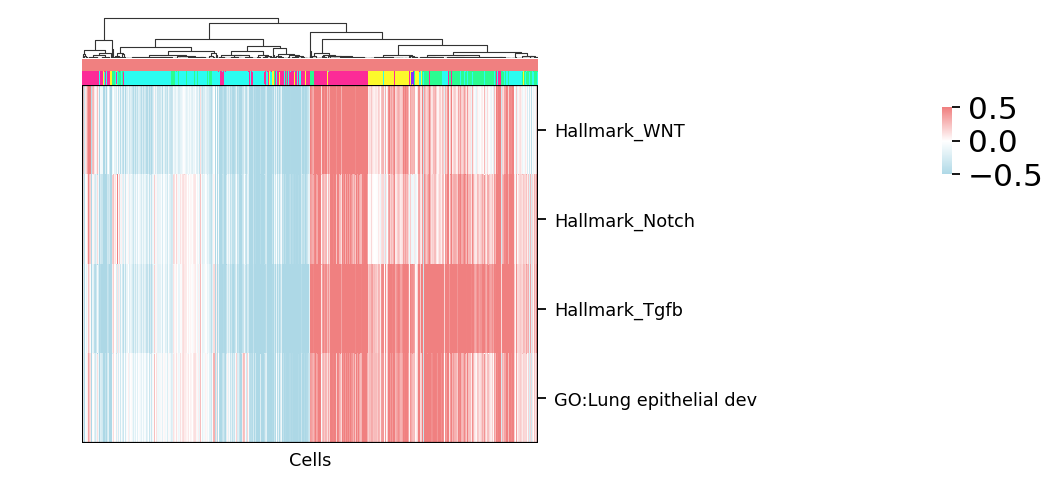

In [19]:
cancer_df = bdata_trans.copy()

df = pd.DataFrame(index=bdata_trans.obs.index)

pathways=['Hallmark_WNT','Hallmark_Notch','Hallmark_Tgfb','GO:Lung epithelial dev']


for path in pathways:
    df[path]=cancer_df.obs[path]
 
z_scores = sc.pp.scale(cancer_df, copy=True)

cols=['Hallmark_WNT','Hallmark_Notch','Hallmark_Tgfb','GO:Lung epithelial dev']

df = df[cols]
    
df = df.T

# leiden colors - first row

louvain = cancer_df.obs['leiden0_1'].astype('object')
lut = {
    '0':'#2BFCF1',
    '1':'#FC2B97',
    '2':'#2BFC91',
    '3':'#FCF92B',
    '4':'#892BFC'  
}

col_colors = louvain.map(lut)

# grouped annotations colors - third row
louvain3 = cancer_df.obs['grouped_annotations'].astype('object')
lut3 = {
'Sca1+ Organoid': 'gold',
'Sca1+ DsRed-': 'lightblue',
'Sca1+ DsRed+': 'lightcoral'
}

col_colors3 = louvain3.map(lut3)

# plot

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['lightblue','white','lightcoral'])

g = sb.clustermap(df, vmin=-0.5, vmax=0.5, cmap=cmap, metric="correlation", row_cluster=False, col_cluster=True,
                   figsize=(6,6), cbar_pos=(1, 0.8, .01, .07), # locxaxis,locyaxis,cbarwidth,cbarheight
                   col_colors=[col_colors3, col_colors], dendrogram_ratio=0.1
                   ) 
ax = g.ax_heatmap
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel("Cells", fontsize=8)
ax.axhline(len(df.index), linewidth=1, color='black')
ax.axhline(0, linewidth=1, color='black')
ax.axvline(len(df.columns), linewidth=1, color='black')
ax.axvline(0, linewidth=1, color='black')

### RNA Velocity analysis using "transitional" SPO clusters

In [4]:
import scvelo as scv

# crete anndata using velocyto loom output files
filenames = [
'/n/data2/bch/hemonc/ckim/SHARON/20200211_transplant_scRNASeq/FC_05786/Unaligned_1234a_PF_TenX_mm1/cellranger/cellranger_count/FEB4_POOL1_SL7_SI-GA-B5/velocyto/FEB4_POOL1_SL7_SI-GA-B5.loom',
'/n/data2/bch/hemonc/ckim/SHARON/20200211_transplant_scRNASeq/FC_05786/Unaligned_1234a_PF_TenX_mm1/cellranger/cellranger_count/FEB4_POOL1_SL8_SI-GA-B6/velocyto/FEB4_POOL1_SL8_SI-GA-B6.loom',
]

vdatas = [sc.read_loom(filename) for filename in filenames]
vdata = vdatas[0].concatenate(vdatas[1:], batch_categories=['SL7','SL8'])
vdata.var_names_make_unique() 

# Make a copy of adata files with computed UMAP for merging with loom anndata files
bdata_velo = bdata_trans.copy()

''''''''''
Merge velocyto data with filtered adata contain computed UMAP

Credit: Merging scvelo with adata
https://github.com/theislab/scvelo/issues/37

'''''''''

merged = scv.utils.merge(bdata_velo, vdata)
print('Number of cells after merge:',len(merged.obs.index))


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Making variable names unique for controlled concatenation.


Number of cells after merge: 5352


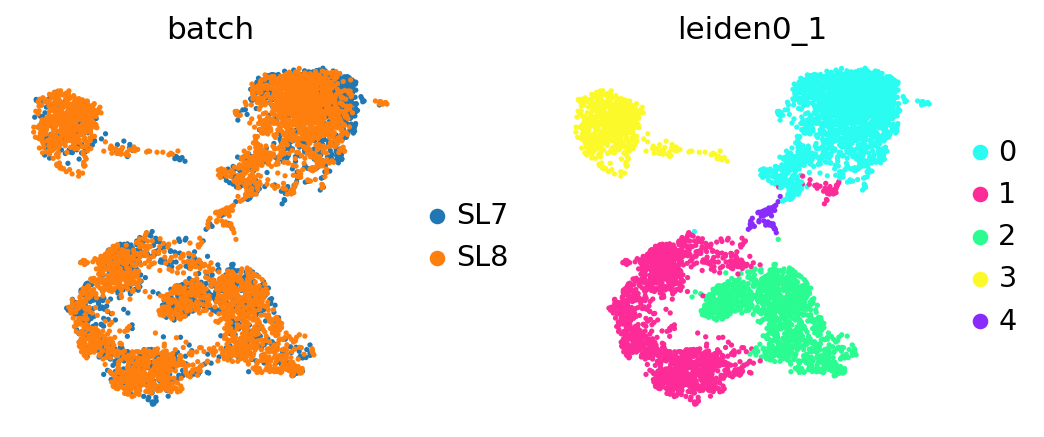

In [7]:
# check UMAP after velo merge
rcParams['figure.figsize']=3,3
rcParams['figure.facecolor']='white'
sc.pl.umap(merged, color=['batch','leiden0_1'], frameon=False)

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:07) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


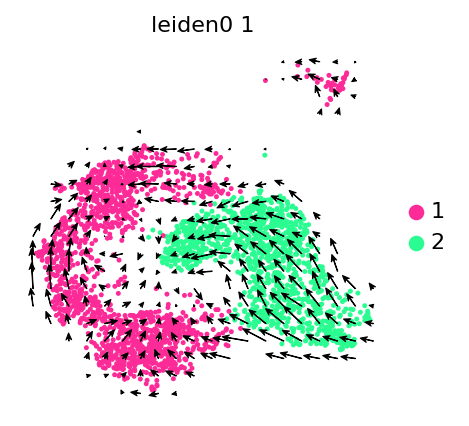

In [10]:
# subset cluster 1 and 2
bdata_clust_1_2 = merged[merged.obs['leiden0_1'].isin(['1','2'])]

# Create velocity graphs
scv.pp.moments(bdata_clust_1_2, n_neighbors=50, n_pcs=20, use_rep='SC')
scv.tl.velocity(bdata_clust_1_2)
scv.tl.velocity_graph(bdata_clust_1_2)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['lightgrey','red'])
arrow_color='black'
size=20
figsize=(3,3)
fontsize=10

with axes_style({'axes.grid': False}):
 ax=scv.pl.velocity_embedding_grid(bdata_clust_1_2, density=0.4, basis='umap', arrow_length=3, arrow_size=3, 
 alpha=1, color=['leiden0_1'], legend_loc='right margin', size=size, ncols=2, 
 figsize=figsize, dpi=(80), frameon=False, color_map=cmap, fontsize=10, legend_fontsize=10,
 vmin=0, vmax=2, arrow_color=arrow_color, use_raw=False, linewidth=0.5)

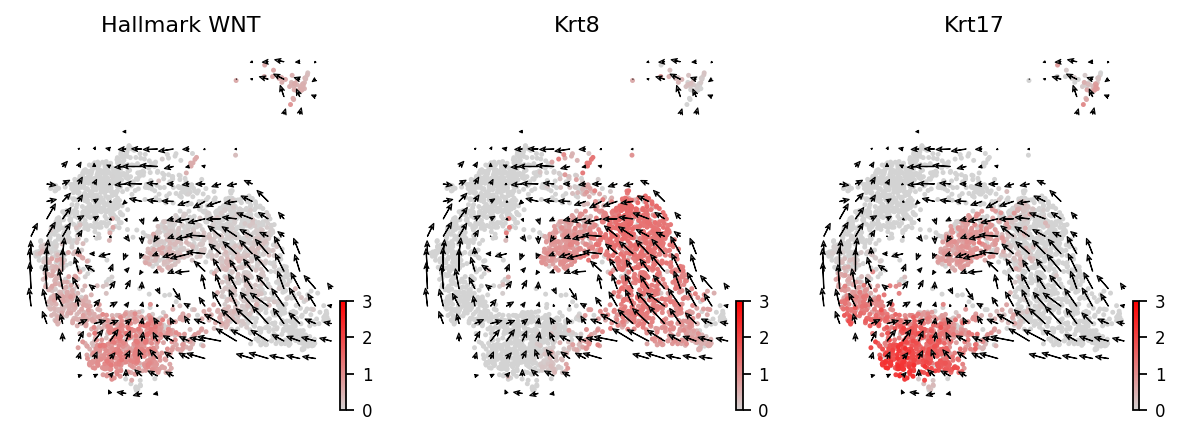

In [13]:
scaled = sc.pp.scale(bdata_clust_1_2, copy=True)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['lightgrey','red'])
arrow_color='black'
size=20
figsize=(3,3)
fontsize=10

with axes_style({'axes.grid': False}):
 ax=scv.pl.velocity_embedding_grid(scaled, density=0.4, basis='umap', arrow_length=3, arrow_size=3, 
 alpha=1, color=['Hallmark_WNT','Krt8','Krt17'], legend_loc='right margin', size=size, ncols=3, 
 figsize=figsize, dpi=(80), frameon=False, color_map=cmap, fontsize=10, legend_fontsize=10,
 vmin=0, vmax=3, arrow_color=arrow_color, use_raw=False, linewidth=0.5)

### Additional analysis of SCA1+ organoid (SPO) data

Text(0.5, 1.0, '')

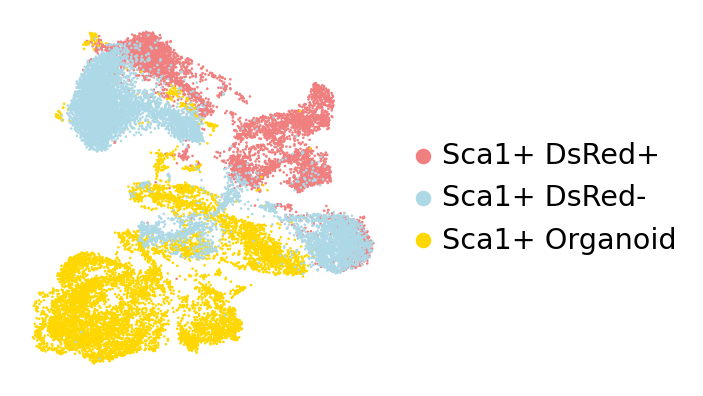

In [8]:
# load the data
rcParams['figure.figsize']=3,3
rcParams['figure.facecolor']='white'
sc.pl.umap(bdata_subset, color='grouped_annotations', frameon=False, show=False)
plt.title('')

#### Subset SPO data then recompute the UMAP

Text(0.5, 1.0, '')

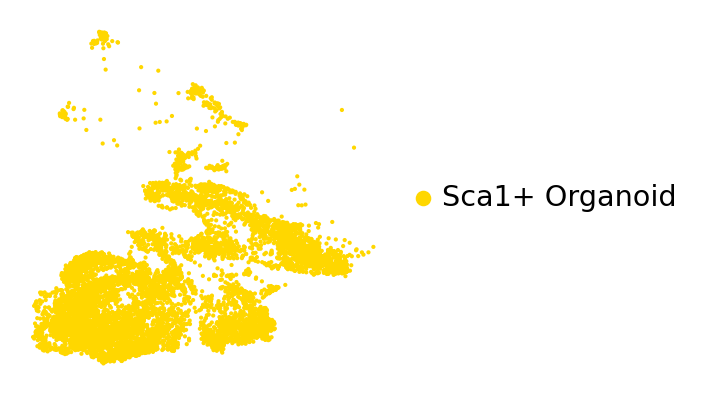

In [24]:
# Subset organoid cells
orgs = bdata_subset[bdata_subset.obs['grouped_annotations'].isin(['Sca1+ Organoid'])]

# plot
sc.pl.umap(orgs, color='grouped_annotations', frameon=False, show=False)
plt.title('')

Text(0.5, 1.0, '')

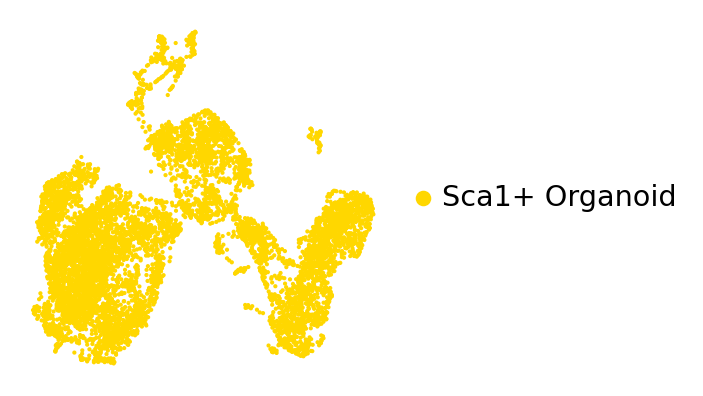

In [25]:
# Recalculate the knn and UMAP
sc.pp.neighbors(orgs, n_neighbors=5, n_pcs=20, use_rep='SC')
sc.tl.umap(orgs)

# plot
sc.pl.umap(orgs, color='grouped_annotations', frameon=False, show=False)
plt.title('')

Text(0.5, 1.0, '')

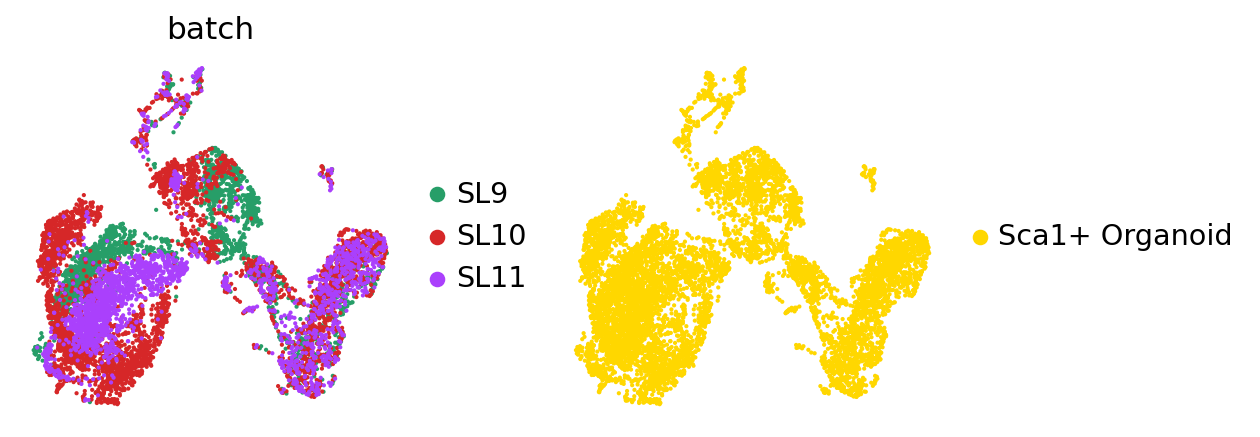

In [39]:
# Check that the batch distirbution is even across the UMAP
sc.pl.umap(orgs, color=['batch','grouped_annotations'], frameon=False, show=False)
plt.title('')

In [53]:
# Canonical marker gene expression
marker_dict = {}
marker_dict['AT2']=['Sftpc','Sftpb','Lyz2']
marker_dict['AT1']=['Hopx','Pdpn','Ager']
marker_dict['Ciliated']=['Foxj1','Cd24a','Tubb4a']
marker_dict['Club']=['Scgb1a1','Cyp2f2']
marker_dict['BASC']=['Ly6a']
marker_dict['AEP']=['Axin2','Tm4sf1']
marker_dict['SPC- a5b4+ Alveolar Progenitors']=['Itga6','Itgb4']
marker_dict['Basal']=['Trp63','Krt5','Krt14','Ngfr']
marker_dict['Goblet']=['Muc5b','Muc5ac','Spdef']
marker_dict['NE']=['Syp','Uchl1','Chga']

# basal cells express Pdpn - doi:10.1038/nm.3642

'''
Sftpc, Sftpb, Lyz2 = AT2
    - Sftpb and Lyz2 are much better AT2 markers than Sftpc
Foxj1, Cd24a, Tubb4a = Ciliated
Scgb1a1, Cyp2f2 = Club
Hopx, Pdpn, Ager = AT1
Axin2, Tm4sf1 = AEPs
Ly6a = BASCs
Trp63, Krt5, Krt14, Nfgr, Pdpn = Basal
Muc5b, Muc5ac, Spdef = Goblet
Itga6, Itgb4 = SPC- a5b4+ alveolar progenitors (Chapman et al, PMID: 21701069) 
'''

'\nSftpc, Sftpb, Lyz2 = AT2\n    - Sftpb and Lyz2 are much better AT2 markers than Sftpc\nFoxj1, Cd24a, Tubb4a = Ciliated\nScgb1a1, Cyp2f2 = Club\nHopx, Pdpn, Ager = AT1\nAxin2, Tm4sf1 = AEPs\nLy6a = BASCs\nTrp63, Krt5, Krt14, Nfgr, Pdpn = Basal\nMuc5b, Muc5ac, Spdef = Goblet\nItga6, Itgb4 = SPC- a5b4+ alveolar progenitors (Chapman et al, PMID: 21701069) \n'

AT2 genes
AT1 genes
Ciliated genes
Club genes
BASC genes
AEP genes
SPC- a5b4+ Alveolar Progenitors genes
Basal genes
Goblet genes
NE genes


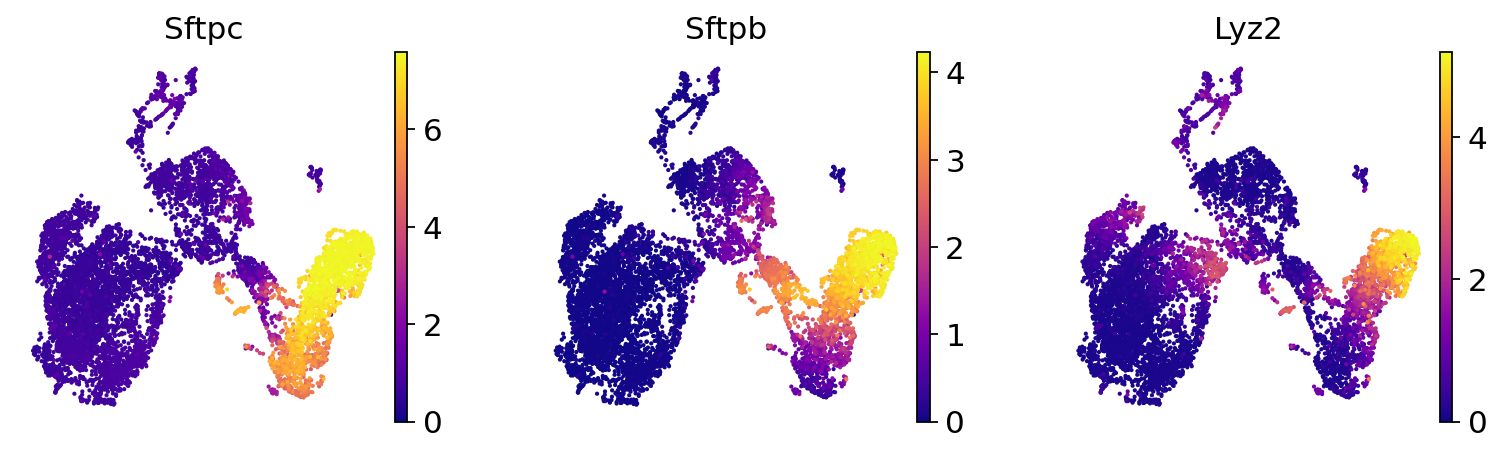

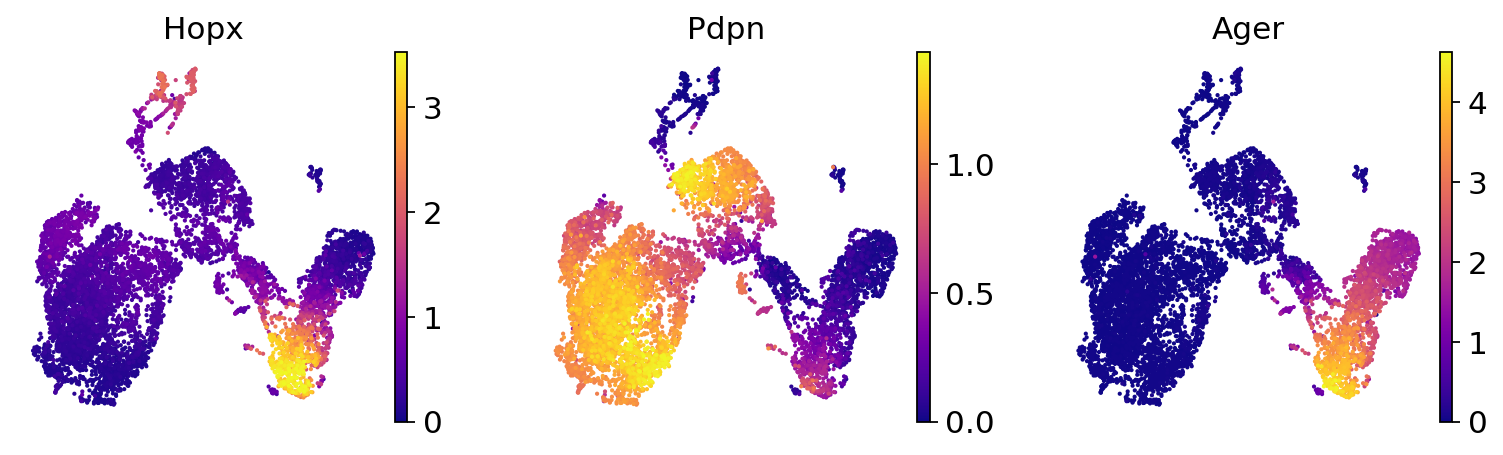

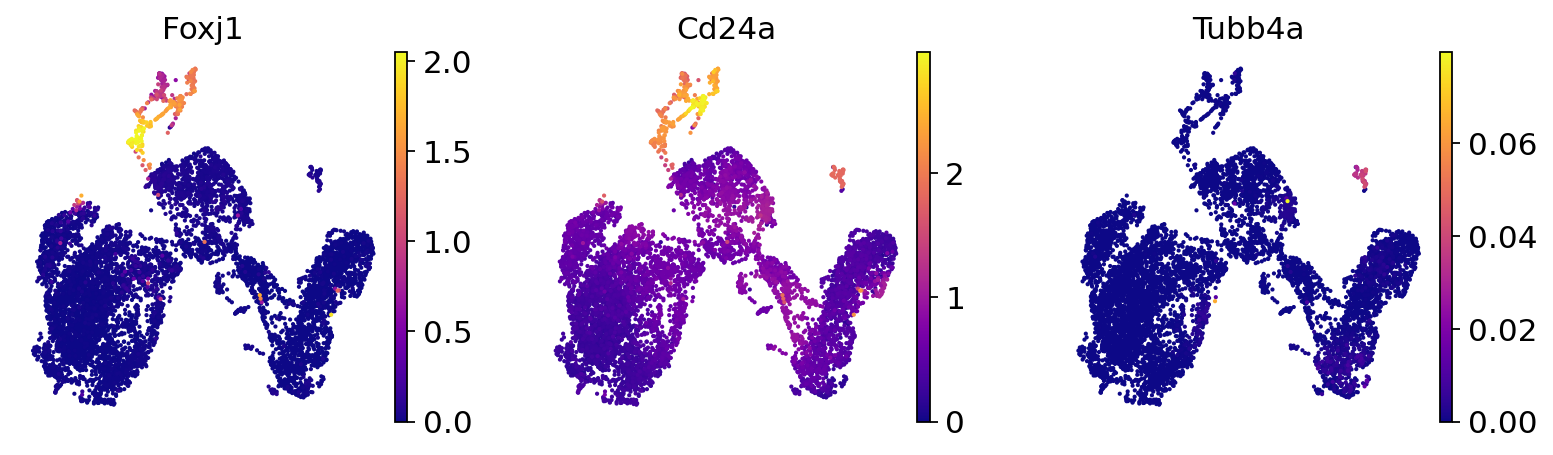

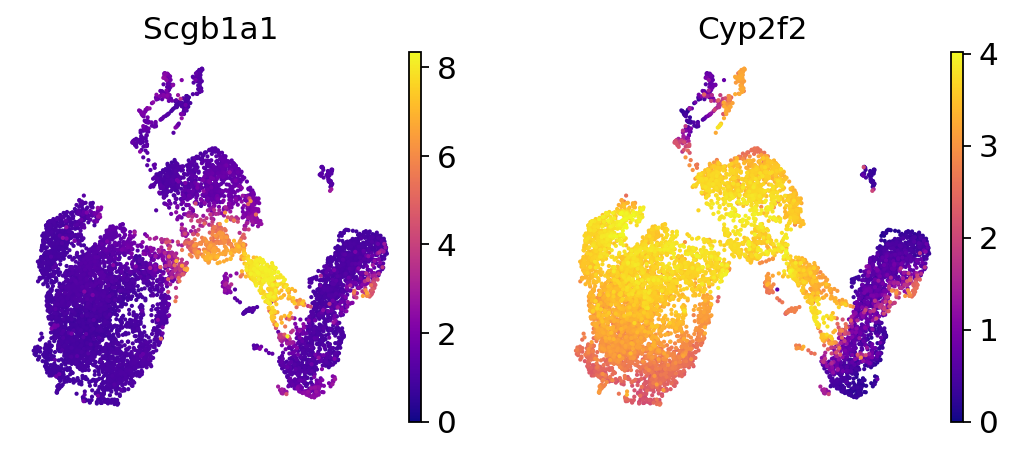

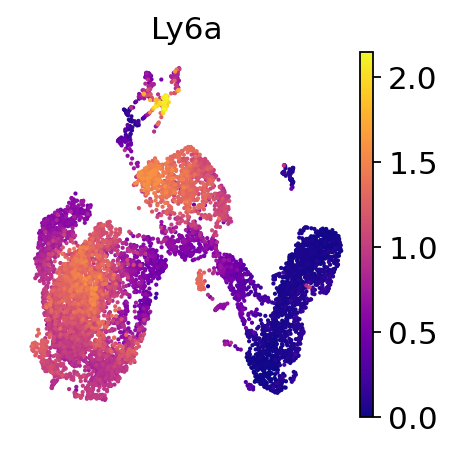

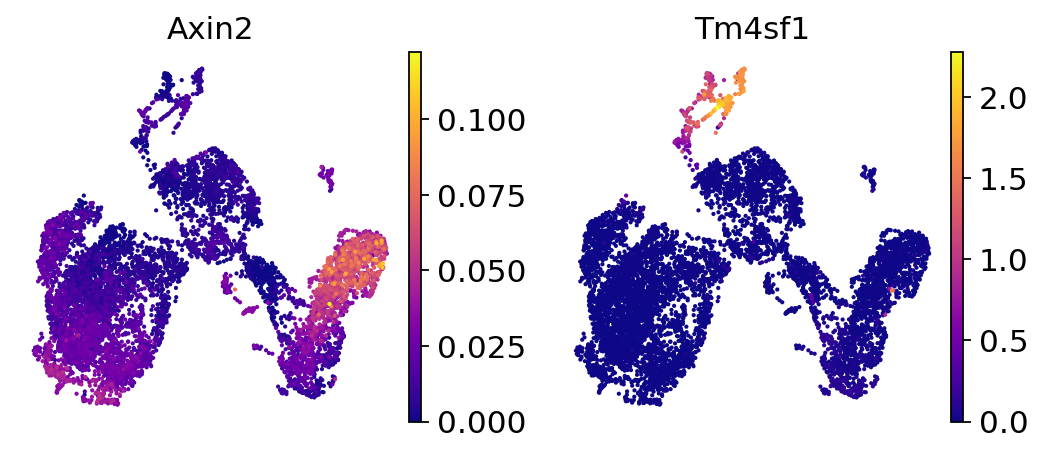

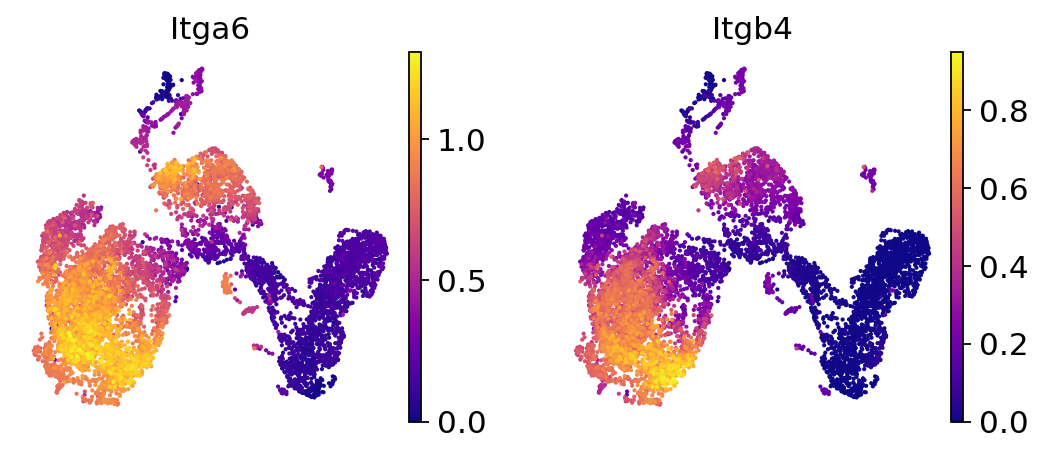

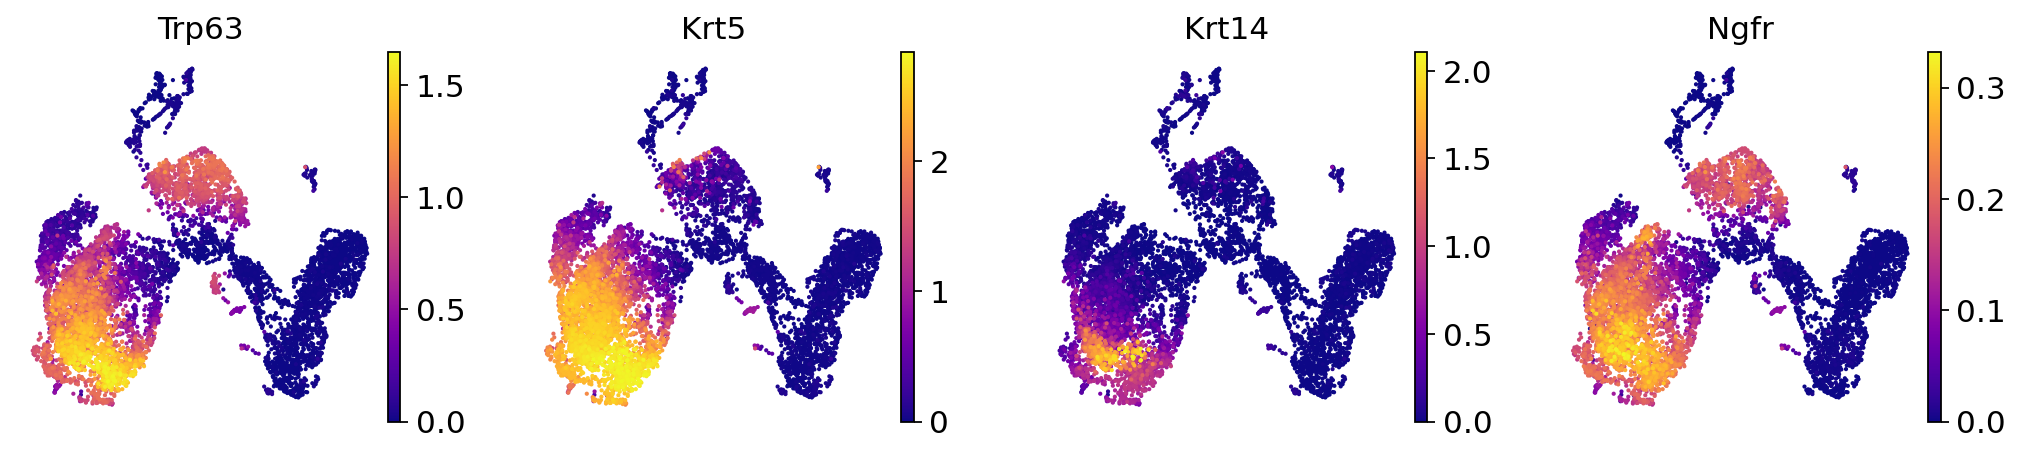

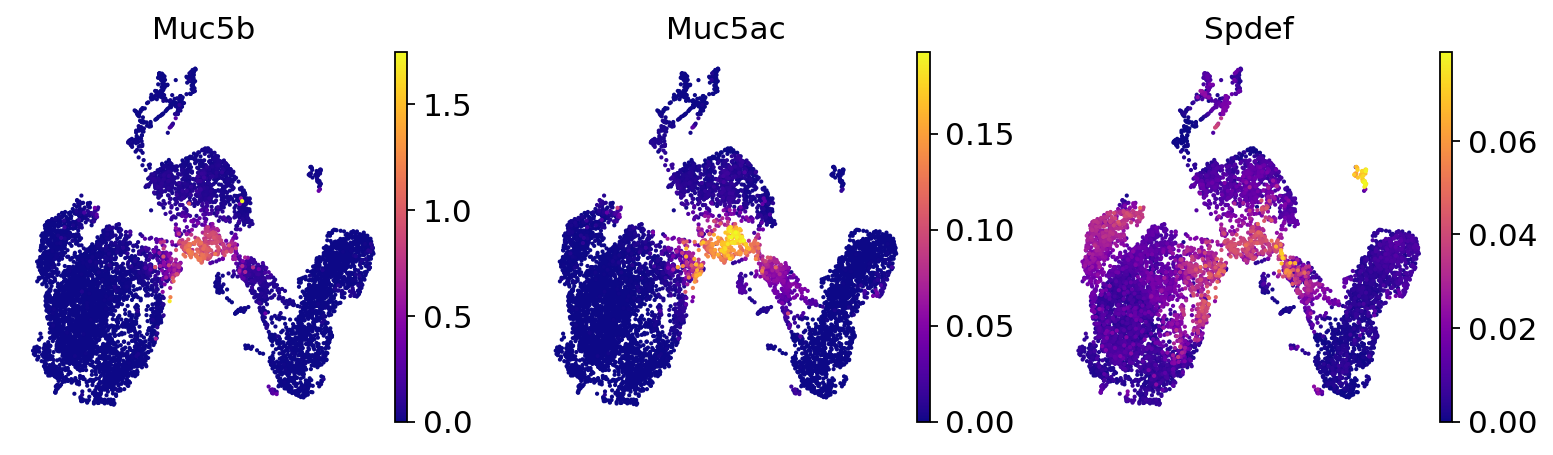

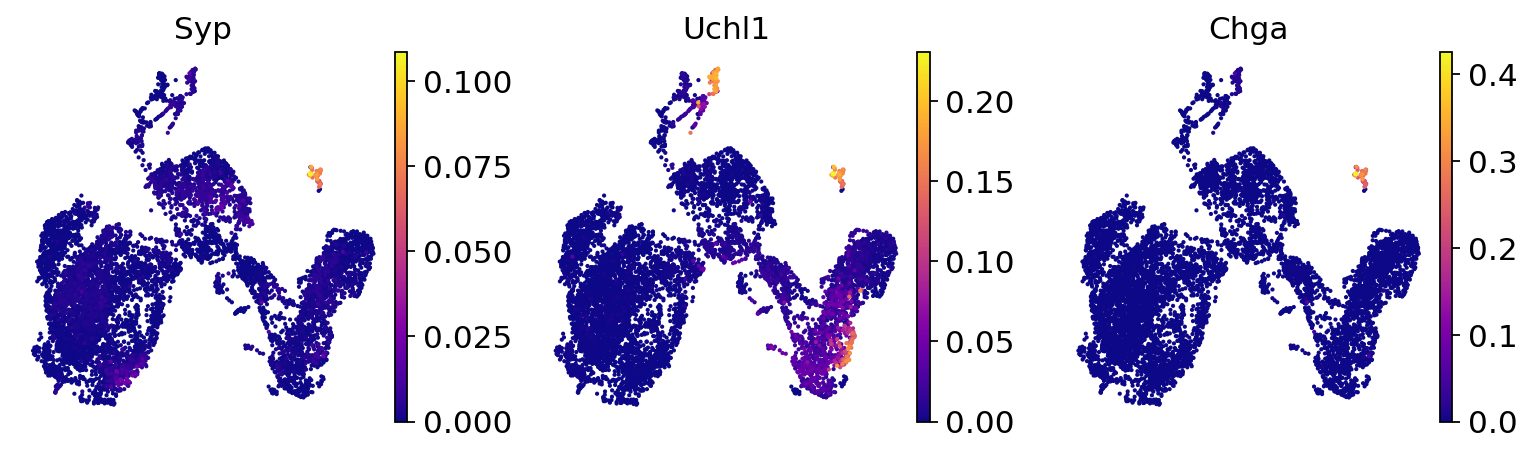

In [54]:
# plot
for k,v in marker_dict.items():
    print(f'{k} genes')
    sc.pl.umap(orgs, color=v, frameon=False, use_raw=False, color_map='plasma', vmin=0, show=False)